In [ ]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

--2019-12-03 08:08:27--  https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 packet.net internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz [following]
--2019-12-03 08:08:32--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88706549 (85M) [application/octet-stream]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[========

In [ ]:
using Pkg

pkg"add NamedArrays"
pkg"add Plots"

pkg"precompile"

using NamedArrays
using Plots

using LinearAlgebra
using Random

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed InvertedIndices ──── v1.0.0
 Installed Requires ─────────── v0.5.2
 Installed RecipesBase ──────── v0.7.0
 Installed Combinatorics ────── v1.0.0
 Installed NamedArrays ──────── v0.9.3
 Installed OrderedCollections ─ v1.1.0
 Installed DataStructures ───── v0.17.6
 Installed Polynomials ──────── v0.6.0
  Updating `~/.julia/environments/v1.0/Project.toml`
  [86f7a689] + NamedArrays v0.9.3
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [861a8166] + Combinatorics v1.0.0
  [864edb3b] + DataStructures v0.17.6
  [41ab1584] + InvertedIndices v1.0.0
  [86f7a689] + NamedArrays v0.9.3
  [bac558e1] + OrderedCollections v1.1.0
  [f27b6e38] + Polynomials v0.6.0
  [3cdcf5f2] + RecipesBase v0.7.0
  [ae029012] + Requires v0.5.2
 Resolving package versions...
 Installed NaNMath ─────────── v0.3.3
 Installed Reexport ────────── v0.2.0


┌ Info: Precompiling NamedArrays [86f7a689-2022-50b4-a561-43c23ac3c673]
└ @ Base loading.jl:1192


Precompiling Plots


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


# Machine learning empiricism #

## Our example data (again) ###

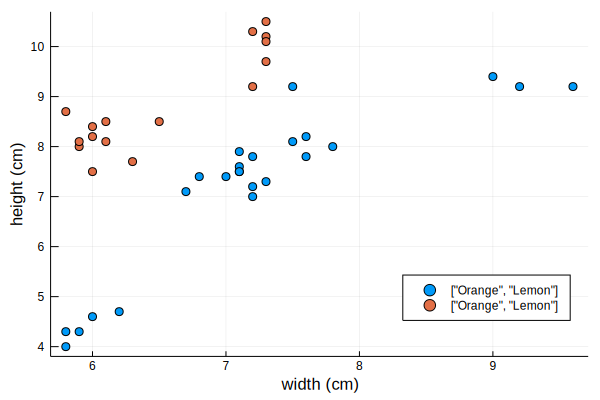

In [ ]:
run(`curl -fsS https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/fruit_data -o /tmp/fruit_data.tsv`)
run(`curl -fsS https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/fruit_types.txt -o /tmp/fruit_types.txt`)

id2fruit = Dict{Int,Symbol}()
open("/tmp/fruit_types.txt") do f
    for l in eachline(f)
        idstr, description = split(l, limit=2)
        id = parse(Int, idstr)
        if occursin(r"orange"i, description) || occursin(r"mandarin"i, description)
            id2fruit[id] = :orange
        elseif occursin(r"lemon"i, description)
            id2fruit[id] = :lemon
        elseif occursin(r"apple"i, description)
            id2fruit[id] = :apple
        else
            error("Unable to detect fruit in descreption: \"$(description)\"")
        end
    end
end

labels  = Symbol[]
datatmp = Vector{Vector{Float64}}()
open("/tmp/fruit_data.tsv") do f
    for l in eachline(f)
        soup   = split(l, limit=4)
        fruit  = id2fruit[parse(Int, soup[1])]
        mass   = parse(Int, soup[2])
        height = parse(Float64, soup[3])
        width  = parse(Float64, soup[4])
        push!(labels, fruit)
        push!(datatmp, [mass, height, width])
    end
end
data = NamedArray(reduce(hcat, datatmp))
setdimnames!(data, "Attribute", 1)
setnames!(data, ["Mass", "Height", "Width"], 1)
setdimnames!(data, "Sample", 2)

run(`rm -f /tmp/fruit_data.tsv /tmp/fruit_types.txt`)
nothing

orangeidx = findall(x -> x == :orange, labels)
lemonidx  = findall(x -> x == :lemon, labels)
scatter(
    [data["Height", orangeidx], data["Height", lemonidx]],
    [data["Width", orangeidx], data["Width", lemonidx]],
    labels=["Orange", "Lemon"], xlabel="width (cm)", ylabel="height (cm)",
    legend=:bottomright)

## What is our goal with any modelling? ##

Let us for a moment take a step back and consider what we want to achieve with any data classification modelling.

We want to create some function, that takes an instance, and makes a prediction:

$$ f(x) = y^\prime $$


In [ ]:
w = zeros(2)
b = 0.0
f(w, b, x) = dot(w, x) + b > 0;

How do we learn (fit) the parameters ($w$ and $b$) of this function? We need observations:

$$ \mathcal{D} = \{(x_1, y_1), \ldots, (x_n, y_n)\} $$

Which in our cases consists three measurements of 24 oranges and 16 lemons, as silly as it sounds.

$$ x_i \in \mathbb{R}^2 $$

$$ y_i \in \{\textrm{orange}, \textrm{lemon}\}$$


In [ ]:
data[["Height", "Width"], [orangeidx; lemonidx]]

2×40 Named Array{Float64,2}
Attribute ╲ Sample │    4     5     6     7  …    56    57    58    59
───────────────────┼──────────────────────────────────────────────────
Height             │  6.2   6.0   5.8   5.9  …   6.3   5.9   6.5   6.1
Width              │  4.7   4.6   4.3   4.3  …   7.7   8.1   8.5   8.1

Now, another step back, what would av ideal function $f$ do? Assuming we had access to all oranges and lemons that has existed and will ever exist $\mathcal{D}_t$:

$$
    \forall_i (x_i, y_i) \in \mathcal{D}_t;
    f(x_i) = y^\prime_i = y_i
$$

However, $\mathcal{D}_t$ is for all “interesting” cases unobtainable. We can thus only ever observe a subset of the true set: $\mathcal{D} \subset \mathcal{D}_t$, where $|\mathcal{D}| \ll |\mathcal{D}_t|$.

Now assuming that we have more than one set of weights $\{w_1, \ldots, w_m\}$, how do we decide which set of weight are the best? Stating that $w_i$ is the “best” is an empirical claim after all.


![](https://www.codeproject.com/KB/AI/1146582/validation.PNG)

[Image source](https://www.codeproject.com/Articles/1146582/Introduction-to-Machine-Learning)

### Split sizes ###

So we need three splits, how big should they be? There are no strict rules, but the general guideline is that the training set is largest, because otherwise you will be unable to learn much about the true distribution. The second largest is then the test set as we want a good estimate of the generalisation power of the model. Lastly, we consider the validation set, not because it is not important, but rather that it is the least important out of the three.

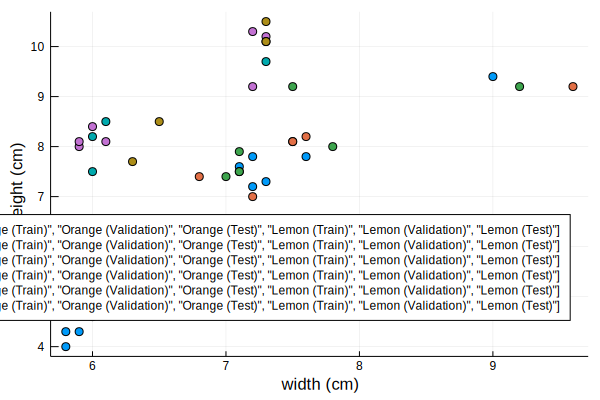

In [ ]:
shuffle!(orangeidx)
orangetrainidx = orangeidx[1:Int(round(length(orangeidx)*(3/6)))]
orangevalidx = orangeidx[length(orangetrainidx):length(orangetrainidx) + Int(round(length(orangeidx)*(1/6)))]
orangetestidx = orangeidx[length(orangetrainidx) + length(orangevalidx) + 1:end]
@assert length(orangetrainidx) + length(orangevalidx) + length(orangetestidx) == length(orangeidx)

shuffle!(lemonidx)
lemontrainidx = lemonidx[1:Int(round(length(lemonidx)*(3/6)))]
lemonvalidx = lemonidx[length(lemontrainidx):length(lemontrainidx) + Int(round(length(lemonidx)*(1/6)))]
lemontestidx = lemonidx[length(lemontrainidx) + length(lemonvalidx) + 1:end]
@assert length(lemontrainidx) + length(lemonvalidx) + length(lemontestidx) == length(lemonidx)

scatter(
    [data["Height", orangetrainidx], data["Height", orangevalidx],
        data["Height", orangetestidx], data["Height", lemontrainidx],
        data["Height", lemonvalidx], data["Height", lemontestidx]],
    [data["Width", orangetrainidx], data["Width", orangevalidx],
        data["Width", orangetestidx], data["Width", lemontrainidx],
        data["Width", lemonvalidx], data["Width", lemontestidx]],
    labels=["Orange (Train)", "Orange (Validation)", "Orange (Test)",
            "Lemon (Train)", "Lemon (Validation)", "Lemon (Test)"],
        xlabel="width (cm)", ylabel="height (cm)", legend=:bottomright)

In [ ]:
function accuracy(oidx, lidx, w, b)
    correct = 0
    for i in oidx
        f(w, b, data[["Height", "Width"], i]) || continue
        correct += 1
    end
    for i in lidx
        !f(w, b, data[["Height", "Width"], i]) || continue
        correct += 1
    end
    correct/(length(oidx) + length(lidx))*100
end

@show accuracy(orangetrainidx, lemontrainidx, w, b)
@show accuracy(orangevalidx, lemonvalidx, w, b)
@show accuracy(orangetestidx, lemontestidx, w, b);

accuracy(orangetrainidx, lemontrainidx, w, b) = 40.0
accuracy(orangevalidx, lemonvalidx, w, b) = 44.44444444444444
accuracy(orangetestidx, lemontestidx, w, b) = 36.36363636363637


In [ ]:
bestw   = copy(w)
bestb   = b
bestacc = 0.0

epochs = 10
for iteration in 1:epochs
    for i in shuffle(vcat(orangetrainidx, lemontrainidx))
        x = data[2:3, i]
        isorange = i in orangeidx
        f(w, b, x) != isorange || continue
        if isorange
            w .+= x
            b  += 1
        else
            w .-= x
            b  -= 1
        end
    end

    @show iteration currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b)
    currentvalacc > bestacc || continue
    bestw[:] = w[:]
    bestb    = b
    bestacc  = currentvalacc
end

w[:] = bestw[:]
b    = bestb

@show accuracy(orangetrainidx, lemontrainidx, w, b)
@show accuracy(orangevalidx, lemonvalidx, w, b)
@show accuracy(orangetestidx, lemontestidx, w, b);

iteration = 1
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 55.55555555555556
iteration = 2
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 3
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 4
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 5
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 6
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 7
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 8
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 9
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
iteration = 10
currentvalacc = accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
accuracy(orangetrainidx, lemontrainidx, w, b) = 100.0
accuracy(orangevalidx, lemonvalidx, w, b) = 100.0
accuracy(orangetestidx, lemontestidx, w, b) = 90.9090909090909


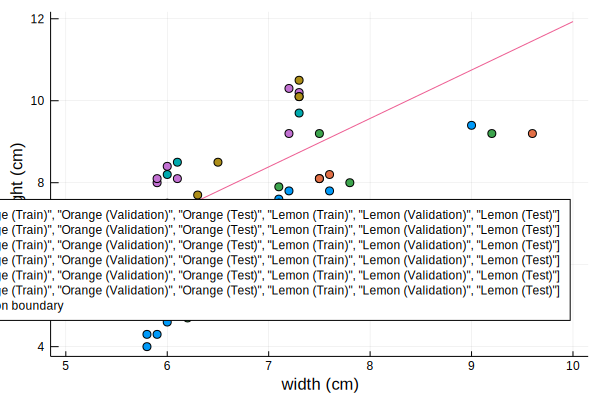

In [ ]:
plt = scatter(
    [data["Height", orangetrainidx], data["Height", orangevalidx],
        data["Height", orangetestidx], data["Height", lemontrainidx],
        data["Height", lemonvalidx], data["Height", lemontestidx]],
    [data["Width", orangetrainidx], data["Width", orangevalidx],
        data["Width", orangetestidx], data["Width", lemontrainidx],
        data["Width", lemonvalidx], data["Width", lemontestidx]],
    labels=["Orange (Train)", "Orange (Validation)", "Orange (Test)",
            "Lemon (Train)", "Lemon (Validation)", "Lemon (Test)"],
        xlabel="width (cm)", ylabel="height (cm)", legend=:bottomright)
k = -(b/w[2])/(b/w[1])
d(x) = k*x + (-b/w[2])
plot!(deepcopy(plt), d, 5:10, label="Decision boundary")

A weakness with the standard train, validation, and test split is that we gain on insight in terms of the variance of the performance on the test set. One could simply use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) as is common in statistics, but this is rarely ever seen in practice.

## Issues in industry ##

But is this really an issue…? Sadly, yes…

### HP MediaSmart facial-tracking ###

![A man of colour and a caucasian women demonstrating how the HP MediaSmart facial-tracking technology does not work for the man’s face](https://i.cdn.turner.com/cnn/2009/TECH/12/22/hp.webcams/story.hp.webcam.youtube.jpg)

“‘HP has been informed of a potential issue with the facial-tracking software included on some of its systems, which appears to occur when insufficient foreground lighting is available,’ an HP spokesman said in an e-mail. ‘We take this seriously and are looking into it with our partners.’” – [Wired](https://www.wired.com/2009/12/hp-notebooks-racist/)

[“HP computers are racist”](https://www.youtube.com/watch?v=TtUmPxhAV70) (2009, YouTube)

### Nikon COOLPIX S630 “blink detection” ###

![A Nikon COOLPIX S630 erronously predicting that an Asian-American is blinking, while her eyes are clearly open](https://farm3.static.flickr.com/2098/3529106844_e8ebe6f9a5.jpg)

A common problem when taking photos is that subjects inadvertantly blink (think group photos). A team at Nikon wanted to address this and implemented a feature for their COOLPIX series. However, in 2009 an Asian-American blogger noted that the camera did not work as expected when taking photos of her mother. What can we assume about their training, validation, and test data? Also, where is Nikon (their name is derived from 日本光学) from again?

[“Racist Camera! No, I did not blink… I’m just Asian!”](http://www.jozjozjoz.com/2009/05/13/racist-camera-no-i-did-not-blink-im-just-asian/) (2009)

## Issues in academia ##

And not just in industry…

## ImageNet challenge in 2015 ##

![Cumulative submissions for the ImageNet 2015 challenge](https://web.archive.org/web/20150704111858im_/http://www.image-net.org/challenges/LSVRC/figs/submissions_server.jpg)

[Image source](https://web.archive.org/web/20150602165531/http://www.image-net.org/challenges/LSVRC/announcement-June-2-2015) (archive.org)

In order to ensure that generalisation was measured, the ImageNet challenge tightly controlled evaluations for the test set by limiting the number of evaluations per day. Requiring you to have an account on their server. One contestant however came up with the genious idea to create multiple accounts so that they could tune their model better and achieve higher performance. The company of the contestant then submitted their paper to arXiv to much fanfare, beating many other companies in the AI sector. However…

[The paper in question](https://arxiv.org/abs/1501.02876) (“This paper has been withdrawn by the authors due to a mistake related to ImageNet server submissions”)

### “On the State of the Art of Evaluation in Neural Language Models” by Melis et al. (2018) ###

*Abstract:* “Ongoing innovations in recurrent neural network architectures have provided a steady influx of apparently state-of-the-art results on language modelling benchmarks. However, these have been evaluated using differing code bases and limited computational resources, which represent uncontrolled sources of experimental variation. We reevaluate several popular architectures and regularisation methods with large-scale automatic black-box hyperparameter tuning and arrive at the somewhat surprising conclusion that standard LSTM architectures, when properly regularised, outperform more recent models.”

In “plain English”:

1. Over the years many people have claimed state-of-the-art results on standard benchmarks
2. However, a model which was introduced many years ago actually perform better if we give equal time and effort to tuning it as all those more recent models we believed were better

[Paper](https://arxiv.org/abs/1707.05589)

### “We need to talk about standard splits” by Gorman and Bedrick (2019) ###

![XXX](https://www.linguisticsweb.org/lib/exe/fetch.php?w=300&tok=894016&media=linguisticsweb:tutorials:linguistics_tutorials:automaticannotation:stanford-corenlp-example.png)

[Image source](http://www.linguisticsweb.org/doku.php?id=linguisticsweb:tutorials:linguistics_tutorials:automaticannotation:stanford_core_nlp)

*Abstract:* “We conduct replication and reproduction experiments with nine part-of-speech taggers published between 2000 and 2018, each of which claimed state-of-the-art performance on a widely-used “standard split”. While we replicate results on the standard split, we fail to reliably reproduce some rankings when we repeat this analysis with randomly generated training-testing splits.”

In “plain English”:

1. As a scientific community we have used the same train, validation, and test split for many years.
2. Over the years various models have claimed to be superior than others based on these splits.
3. However, if we sample new splits, the ranking of the models change, meaning that the observed improvements were dependent on the exact split rather than something intrinsic in the model.

Won one out of four the best paper awards at the [57th Annual Meeting of the Association for Computational Linguistics (ACL)](http://www.acl2019.org/EN/index.xhtml), arguably the top conference in natural language processing. It is worth considering that there were 660 papers accepted to the conference and 2,905 submissions.

[Paper](https://www.aclweb.org/anthology/P19-1267/)

### “RoBERTa: A Robustly Optimized BERT Pretraining Approach” by Liu et al. (2019) ###

![](https://d3i71xaburhd42.cloudfront.net/077f8329a7b6fa3b7c877a57b81eb6c18b5f87de/9-Table6-1.png)

*Abstract:* “Language model pretraining has led to significant performance gains but careful comparison between different approaches is challenging. Training is computationally expensive, often done on private datasets of different sizes, and, as we will show, hyperparameter choices have significant impact on the final results. We present a replication study of BERT pretraining ([Devlin et al., 2019](https://arxiv.org/abs/1810.04805)) that carefully measures the impact of many key hyperparameters and training data size. We find that BERT was significantly undertrained, and can match or exceed the performance of every model published after it. Our best model achieves state-of-the-art results on GLUE, RACE and SQuAD. These results highlight the importance of previously overlooked design choices, and raise questions about the source of recently reported improvements.”

In “plain English”:

1. Devlin et al. (2019) published a model, it showed amazing performance gains across many tasks
2. A plethora of other research appears, some of which claim to outperform Devlin et al. (2019)
3. However, all gains appear incorrect as Devlin et al. (2019) never tuned their model to its limit (understandable, you tune until it works “well enough”) and no work following them bothered to use identical settings for all models

Note that this finding very similar to Melis et al. (2018), but for different tasks.

[Paper](https://arxiv.org/abs/1907.11692)

## Some general guidelines ##

No one has a perfect experimental setup, but here are a few rules of thumb:

1. Always use train, validation, and test splits if you want to make any claims regarding generalisation
2. Perform the split before you start your experiments
3. Keep your test split hidden (some even keep it out of the programme memory until the time comes to evaluate)
4. Evaluate on the test set sparingly (once a day? once every few hours?)
5. Ensure that you keep the experimental setting identical between all compared models

## End-of-lecture questions ##

1. Ignoring the fact that the set of all possible observations $\mathcal{D}_t$ is unobtainable, why is learning a predictive function $f$ uninteresting if we could obtain it?
2. Although one would be hard pressed to find a researcher that would not say that knowing the variance of a model’s performance on the test set, even [k-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) is a rare sight in deep learning papers, why?
3. The findings of Gorman and Bedrick (2019) strongly suggests that as a community a field gradually overfits to any given data, what are possible ways to overcome this?

## Extracurricular reading ##

I do not know of any superb write up about this, but Medawar’s comments on general scientific practice is somewhat comforting in how it confirms that in all fields of science there is a split between the ideal and practice. It is also very short and to the point.

1. [“Is the scientific paper a fraud?”](http://www.weizmann.ac.il/mcb/UriAlon/sites/mcb.UriAlon/files/uploads/medawar.pdf) by Medawar (1964)